# Kats 201 - Forecasting with Kats


This tutorial will introduce time series modeling and forecasting with Kats. We will show you how to build forecasts with different Kats models and how to do parameter tuning and backtesting using Kats.  The complete table of contents for Kats 201 is as follows:

* 1. Forecasting with Kats Base Models
    - 1.1 SARIMA
    - 1.2 Prophet
    - 1.3 Holt-Winters
* 2. Forecasting with Kats Ensemble Model
* 3. Multivariate Model Forecasting
* 4. Hyperparameter Tuning
* 5. Backtesting

**Note:** We provide two types of tutorial notebooks
- **Kats 101**, basic data structure and functionalities in Kats  
- **Kats 20x**, advanced topics, such as advanced forecasting techniques (meta-learning, global model, etc.), advanced detection algorithms (Bayesian online change point detection algorithms, etc), and more.

# 1. Forecasting with Kats Base Models



In this part, we will demonstrate the forecasting workflow with the following models with `air_passengers` data set:
1. `SARIMA`
2. `Prophet`,
3. `Holt-Winters`
4. `Ensemble`



We begin by loading the `air_passengers` data set into a `TimeSeriesData` object.  This code is essentially the same as the code in our introduction to the `TimeSeriesData` object in the Kats 101 Tutorial.

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../")

from kats.consts import TimeSeriesData
air_passengers_df = pd.read_csv("../kats/data/air_passengers.csv")

# Note: If the column holding the time values is not called time, you will want to specify the name of this column.
air_passengers_df.columns = ["time", "value"]
air_passengers_ts = TimeSeriesData(air_passengers_df)

With our Because each of our time series models follow the `sklearn` model API pattern, the code for each of the next three examples is quite similar.  We initialize the model with its parameters and then call the `fit` and `predict` methods.  The only difference between each of these examples are the model-specific parameters.  We can then use the `plot` method to visualize our forecast in each case.

## 1.1 SARIMA

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


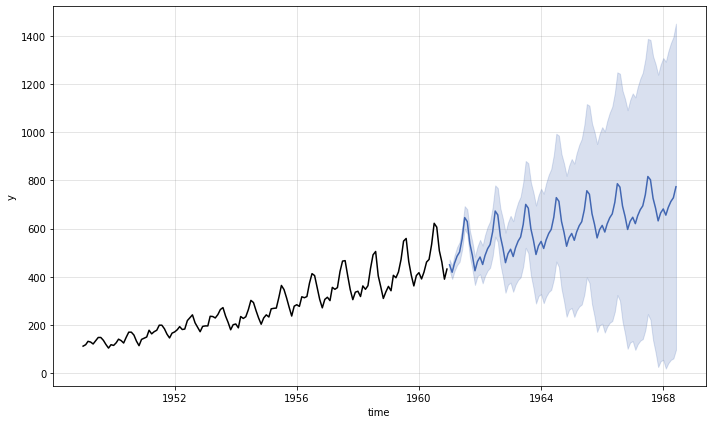

In [2]:
from kats.models.sarima import SARIMAModel, SARIMAParams

# create SARIMA param class
params = SARIMAParams(
    p = 2, 
    d=1, 
    q=1, 
    trend = 'ct', 
    seasonal_order=(1,0,1,12)
    )

# initiate SARIMA model
m = SARIMAModel(data=air_passengers_ts, params=params)

# fit SARIMA model
m.fit()

# generate forecast values
fcst = m.predict(
    steps=90, 
    freq="MS"
    )

# make plot to visualize
m.plot()

## 1.2 Prophet

In [3]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(air_passengers_ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=30, freq="MS")

# plot to visualize
m.plot()

ModuleNotFoundError: No module named 'fbprophet'

## 1.3 Holt-Winters

In [ ]:
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel

params = HoltWintersParams(
            trend="add",
            #damped=False,
            seasonal="mul",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=air_passengers_ts, 
    params=params)

m.fit()
fcst = m.predict(steps=90, alpha = 0.1)
m.plot()

# 2. Forecasting with Ensemble model

We also provided an ensemble forecasting model. It starts from seasonality detection, if seasonality detected, it continues to perform STL decomposition, then fit forecasting models on de-seasonalized components and aggregate; otherwise it simiply leverage individual forecasting models and ensembling. We provided two ensembling methods, weighted average and median ensembling.

In [ ]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (
    arima,
    holtwinters,
    linear_model,
    prophet,
    quadratic_model,
    sarima,
    theta,
)

# we need define params for each individual forecasting model in `EnsembleParams` class
model_params = EnsembleParams(
            [
                BaseModelParams("arima", arima.ARIMAParams(p=1, d=1, q=1)),
                BaseModelParams(
                    "sarima",
                    sarima.SARIMAParams(
                        p=2,
                        d=1,
                        q=1,
                        trend="ct",
                        seasonal_order=(1, 0, 1, 12),
                        enforce_invertibility=False,
                        enforce_stationarity=False,
                    ),
                ),
                BaseModelParams("prophet", prophet.ProphetParams()),
                BaseModelParams("linear", linear_model.LinearModelParams()),
                BaseModelParams("quadratic", quadratic_model.QuadraticModelParams()),
                BaseModelParams("theta", theta.ThetaParams(m=12)),
            ]
        )

# create `KatsEnsembleParam` with detailed configurations 
KatsEnsembleParam = {
    "models": model_params,
    "aggregation": "median",
    "seasonality_length": 12,
    "decomposition_method": "multiplicative",
}

# create `KatsEnsemble` model
m = KatsEnsemble(
    data=air_passengers_ts, 
    params=KatsEnsembleParam
    )

# fit and predict
m.fit()

# predict for the next 90 steps
fcst = m.predict(steps=90)

# aggregate individual model results
m.aggregate()

# plot to visualize
m.plot()

# 3. Multivariate Model Forecasting

In [ ]:
multi_df = pd.read_csv("../kats/data/multi_ts.csv")
multi_ts = TimeSeriesData(multi_df)

In [ ]:
multi_df.groupby('time').sum()[['V1', 'V2']].plot(figsize=(10, 6))

In [ ]:
# Use VAR model to forecast this multivariate time series
from kats.models.var import VARModel, VARParams

params = VARParams()
m = VARModel(multi_ts, params)
m.fit()
fcst = m.predict(steps=90)

# 4. Hyperparameter tuning

To identify which hyperparameters to use for a given model, we have the HyperParameter tuning class in Kats which can efficiently identify the best hyperparameter to use. Below we demonstrate an example of tuning the hyperparameters for an ARIMA model with a Grid Search technique. 

In [ ]:
import kats.parameter_tuning.time_series_parameter_tuning as tpt
from kats.consts import ModelEnum, SearchMethodEnum, TimeSeriesData
from kats.models.arima import ARIMAParams, ARIMAModel

from ax.core.parameter import ChoiceParameter, FixedParameter, ParameterType
from ax.models.random.sobol import SobolGenerator
from ax.models.random.uniform import UniformGenerator

In [ ]:
split = len(air_passengers_df) - int(0.2*len(air_passengers_df))
train, test = air_passengers_df[0:split], air_passengers_df[split:]

train_ts = TimeSeriesData(train)
test_ts = TimeSeriesData(test)

def evaluation_function(params):
    arima_params = ARIMAParams(
        p = params['p'],
        d = params['d'],
        q = params['q']
    )
    model = ARIMAModel(train_ts, arima_params)
    model.fit()
    model_pred = model.predict(steps=len(test))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error

parameters_grid_search = [
{
    "name": "p",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "d",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "q",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
]

In [ ]:
parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)

In [ ]:
parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function, arm_count=-1
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

So we concluded that ARIMA(2,1,1) has the minimal error of 54.8

# 5. Backtesting

We also have a backtesting module which can make it easy to evaluate different forecasting algorithms. Here we demonstrate a simple backtesting using the ARIMA model and the Prophet model

In [ ]:
from kats.utils.backtesters import BackTesterSimple
from kats.models.arima import ARIMAModel, ARIMAParams


backtester_errors = {}
params = ARIMAParams(p=2, d=1, q=1)
ALL_ERRORS = ['mape', 'smape', 'mae', 'mase', 'mse', 'rmse']

backtester = BackTesterSimple(
    ALL_ERRORS,
    air_passengers_ts,
    params,
    75,25, ARIMAModel)

backtester.run_backtest()

In [ ]:
backtester_errors['arima'] = {}
for error, value in backtester.errors.items():
    backtester_errors['arima'][error] = value

In [ ]:
params_prophet = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

backtester_prophet = BackTesterSimple(
    ALL_ERRORS,
    air_passengers_ts,
    params_prophet,
    75,25, ProphetModel)

backtester_prophet.run_backtest()

backtester_errors['prophet'] = {}
for error, value in backtester_prophet.errors.items():
    backtester_errors['prophet'][error] = value

In [ ]:
pd.DataFrame.from_dict(backtester_errors)